# signMNIST 분류 인공지능 모델 구현
## 개요
* 알파벳 A-Z까지 수화로 표현된 이미지를 분류하는 심층 신경망(딥러닝) 모델을 구현하고자 합니다.
* 표현을 위해 모션이 필요한 J와 Z는 데이터셋에 표현되어 있지 않습니다.
## 1. 데이터 전처리

In [33]:
# load libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [34]:
# get data
train_df = pd.read_csv('./sign_mnist_train.csv')
test_df = pd.read_csv('./sign_mnist_test.csv')

In [35]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [36]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


* 총 785개의 열(columns)을 가지는 정형 데이터의 형태로 표현되어 있음
* `label`열은 정답 레이블을 의미하며, 나머지 열들은 왼쪽 위부터 이미지의 픽셀값을 0-255로 표현해놓았음
* 레이블 열은 제외하고, 나머지 열을 비정형 데이터인 28x28의 이미지 데이터로 변경

In [37]:
# 훈련데이터/시험데이터 분리
train_y = train_df['label'].values
train_x = train_df.loc[:, 'pixel1':].values
test_y = test_df['label'].values
test_x = test_df.loc[:,'pixel1':].values

In [38]:
# reshape as input of DNN model
train_x = train_x.reshape((-1,28,28,1))
test_x = test_x.reshape((-1,28,28,1))

In [39]:
# character to ascii code
ord('A')

65

In [40]:
import string

alphabet = list(string.ascii_uppercase)
CLASS_LABELS = [c for c in string.ascii_uppercase if not c == 'J' and not c == 'Z']
label_to_idx = {c:i for i,c in enumerate(CLASS_LABELS)}
idx_to_label = {i:c for i,c in enumerate(CLASS_LABELS)}

train_y = np.array([label_to_idx[alphabet[idx]] for idx in train_y])
test_y = np.array([label_to_idx[alphabet[idx]] for idx in test_y])

(-0.5, 27.5, 27.5, -0.5)

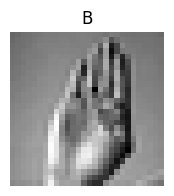

In [45]:
# visualize random single sample
fig, ax = plt.subplots(1,1,figsize=(2,2))
rnd_idx = np.random.randint(low=0, high=train_x.shape[0], size=1)
sample_img = train_x[rnd_idx]
sample_label = train_y[rnd_idx]
ax.imshow(sample_img[0], cmap='gray')
ax.set_title(CLASS_LABELS[sample_label[0]])
ax.axis('off')

In [46]:
#  스케일링[0,255] -> [0.,1.]
train_x = np.divide(train_x, 255.)
test_x = np.divide(test_x, 255.)

In [47]:
np.min(train_x), np.max(train_x)

(0.0, 1.0)

In [48]:
# 레이블 : 원핫인코딩
from sklearn.preprocessing import OneHotEncoder # 써본적 없음
from tensorflow.keras.utils import to_categorical # 제일 쉬움
import numpy as np # 제일 빡셈 -> 사실 아니였다?
# # numpy 방법
# # for i in range(train_x.shape[0]):
# train_y = np.eye(len(CLASS_NAMES))[train_y]

# # OneHotEncoder
# encoder = OneHotEncoder()
# train_y_oh = encoder.fit_transform(train_y)
# test_y_oh = encoder.transform(test_y)

# keras
train_y_oh = to_categorical(train_y, num_classes=len(CLASS_LABELS))
test_y_oh = to_categorical(test_y, num_classes=len(CLASS_LABELS))
train_y_oh.shape, test_y_oh.shape

((27455, 24), (7172, 24))

In [31]:
# 훈련/검증 분리
# from sklearn.model_selection import train_test_split

In [49]:
# modeling
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=4,
                                 kernel_size=3,
                                 strides=1,
                                 padding='same',
                                activation='relu',
                                input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2,
                                      strides=2))
model.add(tf.keras.layers.Conv2D(filters=8,
                                kernel_size=3,
                                strides=1,
                                padding='same',
                                activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2,
                                      strides=2))
model.add(tf.keras.layers.Conv2D(filters=16,
                                kernel_size=3,
                                strides=1,
                                padding='same',
                                activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2,
                                      strides=2))
model.add(tf.keras.layers.Conv2D(filters=32,
                                kernel_size=3,
                                strides=1,
                                padding='same',
                                activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2,
                                      strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(48, activation='relu'))
model.add(tf.keras.layers.Dense(len(CLASS_LABELS), activation='softmax'))

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          1168      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 16)         0

In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [52]:
model.fit(
    x=train_x,
    y=train_y_oh,
    batch_size=64,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
387/387 [==============================] - 6s 7ms/step - loss: 2.2801 - acc: 0.3191 - val_loss: 1.2096 - val_acc: 0.6202
Epoch 2/10
387/387 [==============================] - 2s 6ms/step - loss: 0.8525 - acc: 0.7174 - val_loss: 0.6848 - val_acc: 0.7578
Epoch 3/10
387/387 [==============================] - 2s 6ms/step - loss: 0.4858 - acc: 0.8367 - val_loss: 0.4250 - val_acc: 0.8583
Epoch 4/10
387/387 [==============================] - 3s 6ms/step - loss: 0.3180 - acc: 0.8937 - val_loss: 0.2996 - val_acc: 0.9024
Epoch 5/10
387/387 [==============================] - 2s 6ms/step - loss: 0.2067 - acc: 0.9359 - val_loss: 0.1640 - val_acc: 0.9527
Epoch 6/10
387/387 [==============================] - 3s 7ms/step - loss: 0.1320 - acc: 0.9622 - val_loss: 0.1178 - val_acc: 0.9654
Epoch 7/10
387/387 [==============================] - 3s 7ms/step - loss: 0.0888 - acc: 0.9763 - val_loss: 0.0727 - val_acc: 0.9836
Epoch 8/10
387/387 [==============================] - 2s 6ms/step - loss: 0.

In [53]:
# 예측
model.evaluate(test_x, test_y_oh)

225/225 [==============================] - 1s 3ms/step - loss: 0.6637 - acc: 0.8516


[0.6636853814125061, 0.851645290851593]

In [54]:
# 시험 및 훈련 데이터셋에 예측 진행
test_pred = model.predict(test_x)
test_pred = np.argmax(test_pred, axis=1)
train_pred = model.predict(train_x)
train_pred = np.argmax(train_pred, axis=1)

In [55]:
# 성능 평가를 위해 혼잡 행렬 확인
from sklearn.metrics import confusion_matrix
train_conf = confusion_matrix(y_true=train_y,
                y_pred=train_pred)

In [56]:
train_conf.shape

(24, 24)

* 2개 클래스에 대한 데이터(`J`,`Z`)가 없기 때문에 혼잡 행렬 역시 26개가 아닌 24개만 출력되는 것을 확인할 수 있음
* 그에 대한 레이블 명도 알맞게 조정이 필요함

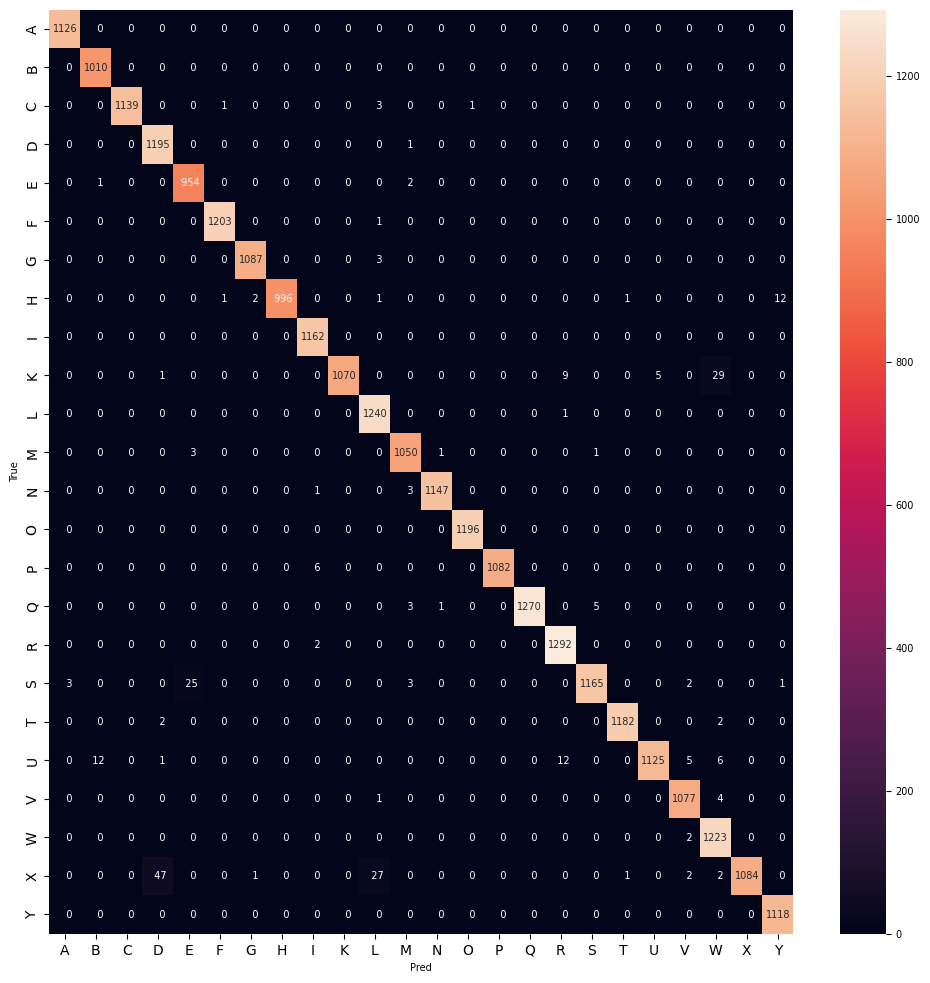

In [60]:
import seaborn as sns
import matplotlib as mpl

font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 7}

mpl.rc('font', **font)

fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(train_conf, annot=True, fmt='4d', ax=ax)
ax.set(xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set(xlabel='Pred', ylabel='True')
plt.show()

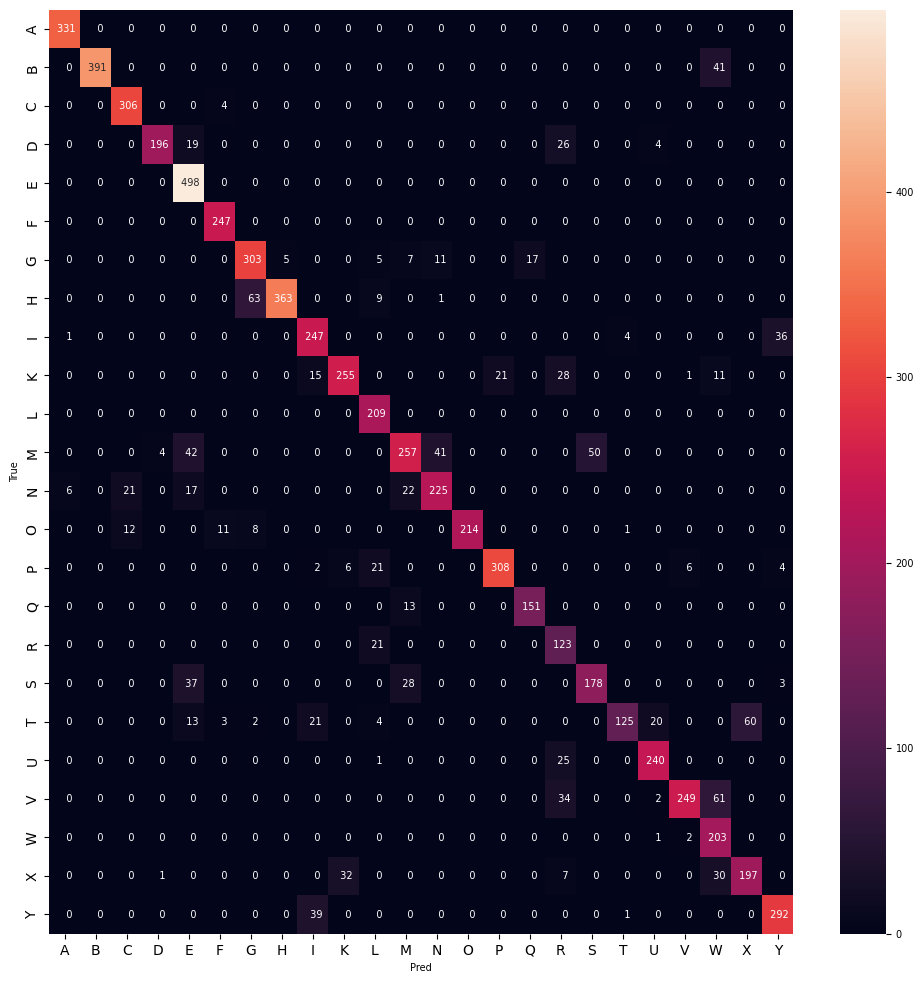

In [61]:
# 시험 데이터에도 확인해 봅시다
# 성능 평가를 위해 혼잡 행렬 확인
test_conf = confusion_matrix(y_true=test_y,
                y_pred=test_pred)
fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(test_conf, annot=True, fmt='4d', ax=ax)
ax.set(xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set(xlabel='Pred', ylabel='True')
plt.show()

* 훈련 데이터에는 대체로 성능이 좋으나 시험 데이터에는 훈련시 만큼의 성능을 보여주지 못함
* 혼잡행렬 확인 결과 `V`를 `R`로 잘못 예측하는 경우가 상당수를 차지
* 이 외에도, 다음과 같은 문제가 산재
    - `T`를 `G`로
    - `B`를 `U`로
    - `L`을 `C`로

In [62]:
# 틀린 데이터 가져오기
incorr_mask = (test_y != test_pred)
incorr_x = test_x[incorr_mask]
incorr_y = test_y[incorr_mask]
incorr_y_hat = test_pred[incorr_mask]

In [63]:
test_x.shape, incorr_x.shape

((7172, 28, 28, 1), (1064, 28, 28, 1))

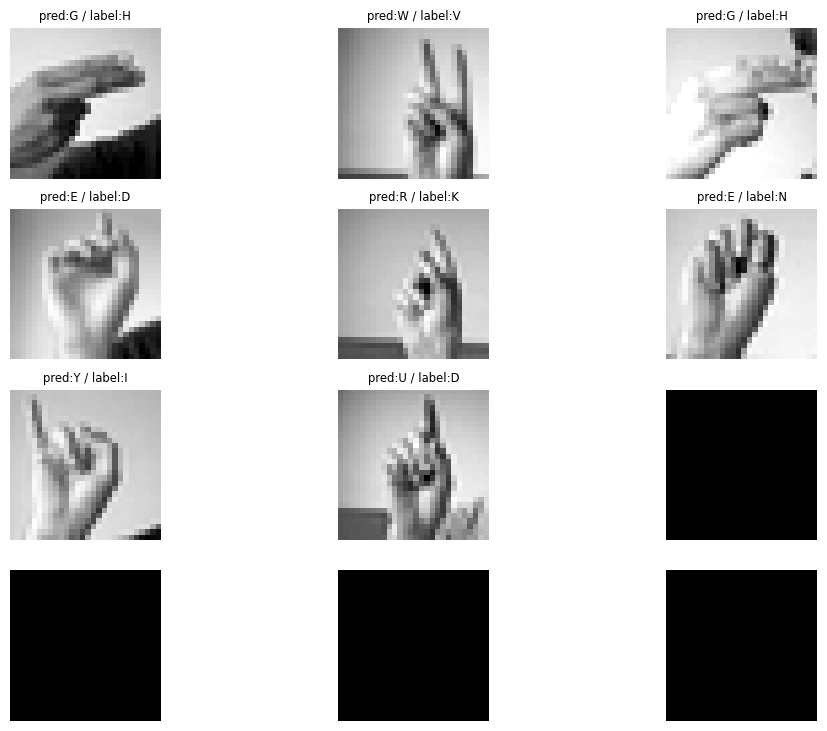

In [66]:
# 틀린 데이터 시각화
num_samples = 10
rand_idx = np.random.choice(np.arange(incorr_x.shape[0]), 10)
samples = incorr_x[rand_idx]
preds = incorr_y_hat[rand_idx] 
labels = incorr_y[rand_idx]

samples_per_row = 3
nrows = int(np.ceil(num_samples/samples_per_row))
fig, axes = plt.subplots(nrows=nrows,
                         ncols=samples_per_row,
                        figsize=(3*nrows,3*samples_per_row))
for i in range(nrows):
    for j in range(samples_per_row):
        try:
            axes[i,j].imshow(samples[i*nrows + j], cmap='gray')
            axes[i,j].set_title(f'pred:{CLASS_LABELS[preds[i*nrows + j]]} / label:{CLASS_LABELS[labels[i*nrows + j]]}')
            axes[i,j].axis('off')
        except IndexError as _:
            axes[i,j].imshow(np.ones((28,28,1), dtype=np.uint8)*255, cmap='gray')
            axes[i,j].axis('off')

* 위 예측 결과를 분석하여 개선방안을 모색해 봅시다